In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("/home/torsten/ms/data/rosbag2_old_zoo_a_09_29/imu.csv")
df

,timestamp,la_x,la_y,la_z,av_x,av_y,av_z
0,1695990713798,-9.636713,-0.539368,-1.459890,0.004794,-0.001065,0.000000
1,1695990713801,-9.643905,-0.544163,-1.459890,0.002663,-0.002663,-0.002663
2,1695990713804,-9.641508,-0.544163,-1.459890,0.003728,-0.000533,-0.001598
3,1695990713806,-9.636713,-0.541766,-1.450301,0.004261,-0.001598,0.001598
4,1695990713809,-9.639111,-0.541766,-1.440713,0.001598,-0.002131,0.003728
...,...,...,...,...,...,...,...
149704,1695991148648,-9.734999,-0.086299,0.666420,0.002131,-0.001598,0.001598
149705,1695991148651,-9.744587,-0.093491,0.668817,0.003196,-0.001065,0.003196
149706,1695991148653,-9.746984,-0.100682,0.666420,0.000533,-0.003728,0.000533
149707,1695991148656,-9.742190,-0.107874,0.666420,0.000000,-0.001598,0.000000


May 2023: Linear acceleration and angular velocity were changed around in the ROS message.  
Stereolabs claim coord system to be Axis: X FORWARD, Y LEFT, Z UP.  
It looks like X points down

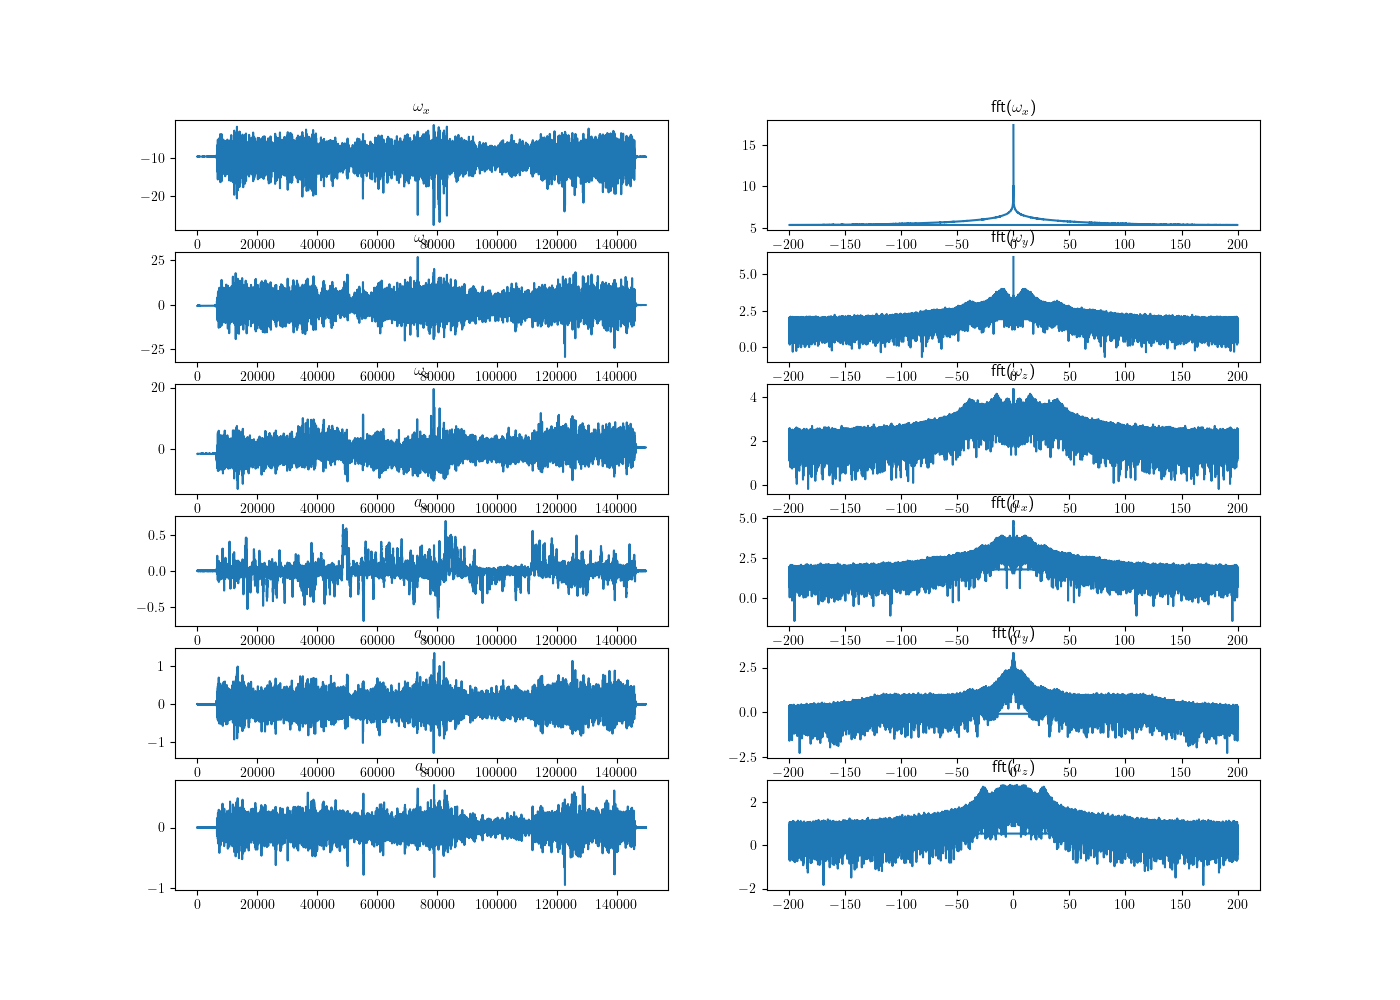

In [3]:
%matplotlib widget
plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
titles = [
    "$\omega_x$",
    "$\omega_y$",
    "$\omega_z$",
    "$a_x$",
    "$a_y$",
    "$a_z$"]

plt.figure(figsize=(14,10))
for i in range(6):
    plt.subplot(6,2,i*2+1)
    plt.title(titles[i])
    plt.plot(df.iloc[:,i+1])
    plt.subplot(6,2,i*2+2)
    plt.title("fft("+titles[i]+")")
    plt.plot(np.fft.fftfreq(df.iloc[:,i].shape[0], 1/400),np.log10(np.abs(np.fft.fft(df.iloc[:,i].values))))
plt.show()
         

# Basic attempt at dead reckoning
Try a two dimensional integration with rotaion around vertial axis and movement forward and back. Use $\omega_x$ as rotational axis and $a_y$ as forward/backward acceleration.

In [4]:
w_x = df.iloc[:,1].values / 57.29578
a_y = df.iloc[:,5].values + 0.2436367406

pos = np.asarray([0, 0], dtype=float) #(x, y)
vel = 0 #m/s
O = 0 # rad/s orientation
dt = 1/400

pos_history = np.zeros((w_x.shape[0], 2))
vel_history = np.zeros((w_x.shape[0], 1))

for i in range(w_x.shape[0]):
    vel += a_y[i] * dt
    vel_history[i] = vel
    delta_s = vel * dt # Displacement at timestep

    O += w_x[i] * dt # Orientation
    delta_x = np.asarray([np.cos(O), np.sin(O)], dtype=float) * delta_s
    pos += delta_x
    pos_history[i, 0] = pos[0]
    pos_history[i, 1] = pos[1]    


<function matplotlib.pyplot.show(block=None)>

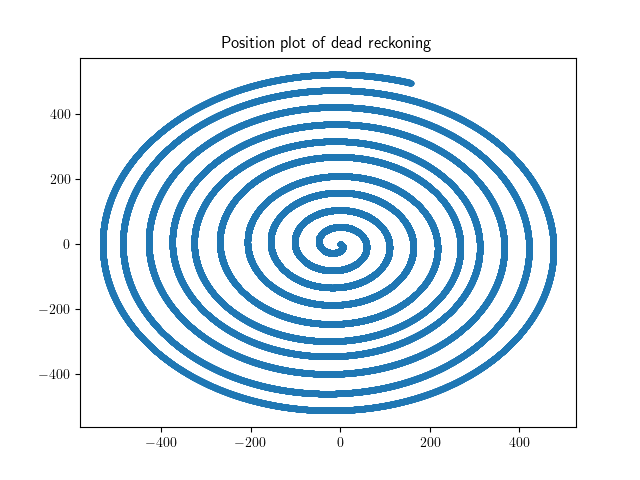

In [5]:
plt.figure()
plt.title("Position plot of dead reckoning")
plt.scatter(pos_history[:, 0], pos_history[:, 1], marker=".")
plt.show

<function matplotlib.pyplot.show(block=None)>

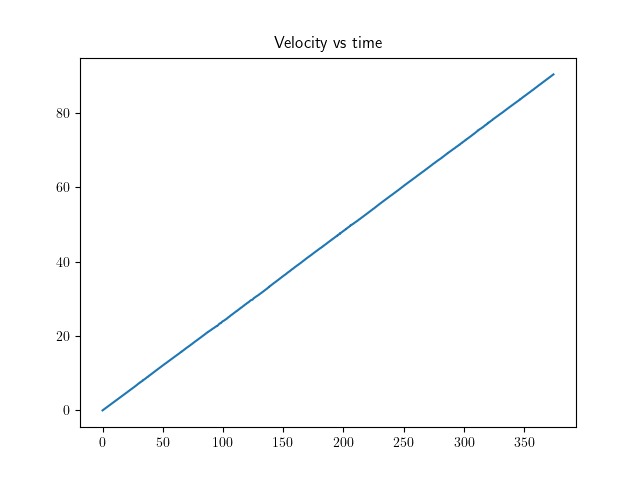

In [6]:
plt.figure()
plt.title("Velocity vs time")
t = np.arange(vel_history.shape[0]) * (1/400)
plt.plot(t, vel_history)
plt.show

# Finding gravity vector

<function matplotlib.pyplot.show(block=None)>

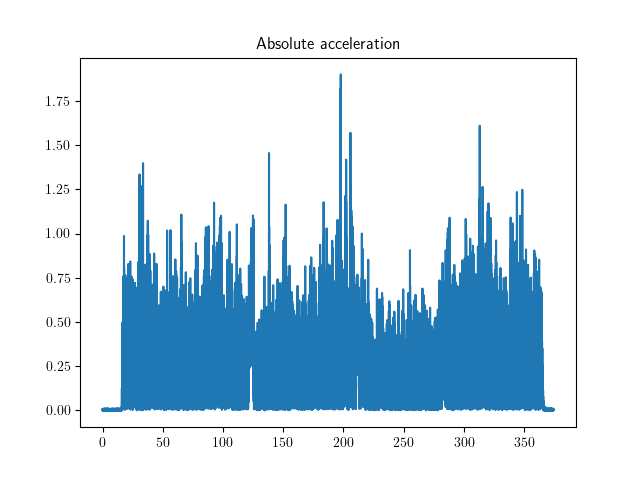

In [7]:
abs_a = np.sqrt(np.power(df.iloc[:,4].values, 2) + np.power(df.iloc[:,5].values, 2) + np.power(df.iloc[:,5].values, 2))

plt.figure()
plt.title("Absolute acceleration")
plt.plot(t, abs_a)
plt.show